# Punto 6. Workshop 6

In [39]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import shapely

plt.rcParams['figure.figsize'] = (10, 8)

root_folder= r"/home/DATA"


SHAPE_MUN = root_folder+r"/municipios_colombia.shp"
EVA_CSV   = root_folder+'/Evaluaciones_Agropecuarias_Municipales_EVA.csv'
EST_CSV   = root_folder+'/Catalogo_Estaciones_IDEAM.csv'
SHAPE_VIAS = root_folder+r"/vias_colombia_V2.shp"

In [40]:
gdf_vias = gpd.read_file(SHAPE_VIAS).to_crs(epsg=9377)

In [41]:
# Municipalities → GeoDataFrame 
gdf_mun = gpd.read_file(SHAPE_MUN).to_crs(epsg=9377)

# EVA table, rename code column
eva = (pd.read_csv(EVA_CSV)
         .rename(columns={"CÓD. MUN.": "cod_mun"}))
eva["CULTIVO"] = eva["CULTIVO"].astype(str)      # ensure string

# IDEAM catalogue → GeoDataFrame (clean "(lat, lon)")
df_est = pd.read_csv(EST_CSV)
coords = (df_est["Ubicación"]
            .str.strip("()")
            .str.split(",", expand=True)
            .astype(float))
df_est["lat"], df_est["lon"] = coords[0], coords[1]

gdf_est = gpd.GeoDataFrame(
    df_est,
    geometry=gpd.points_from_xy(df_est["lon"], df_est["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=9377)

print(f"{len(gdf_mun):,} municipalities • {len(gdf_est):,} stations • "
      f"{len(eva):,} EVA rows")


#Homogenise municipalities codes
gdf_mun["MPIO_CCDGO"] = gdf_mun["MPIO_CCDGO"].astype(str).str.zfill(5)
eva["cod_mun"]        = eva["cod_mun"].astype(str).str.zfill(5)

1,122 municipalities • 8,973 stations • 206,068 EVA rows


# 6.2 Pasos de análisis básicos - Nivel 1: Selección municipal

In [42]:
gdf_mun.head()

gdf_mun['AREA'] = gdf_mun.area

print (gdf_mun)

     DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0            18      00001               FLORENCIA      18001     2018   
1            18      00029                 ALBANIA      18029     2018   
2            18      00094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3            18      00247             EL DONCELLO      18247     2018   
4            18      00256               EL PAUJÍL      18256     2018   
...         ...        ...                     ...        ...      ...   
1117         25      00290              FUSAGASUGÁ      25290     2018   
1118         25      00662     SAN JUAN DE RIOSECO      25662     2018   
1119         73      00349                   HONDA      73349     2018   
1120         05      00631                SABANETA       5631     2018   
1121         05      00380             LA ESTRELLA       5380     2018   

              AREA   LATITUD   LONGITUD  STCTNENCUE  STP3_1_SI  ...  \
0     2.546958e+09  1.749139 -75.558239 

In [43]:
# Paso 1: Convertir la columna a tipo numérico, manejando posibles errores

gdf_mun["DPTO_CCDGO_NUM"] = pd.to_numeric(gdf_mun["DPTO_CCDGO"], errors='coerce')

# Paso 2: Filtrar usando la nueva columna numérica
# Aquí es importante asegurarte de que 15 sea el tipo correcto (int) para la comparación
Boyaca = gdf_mun[gdf_mun["DPTO_CCDGO_NUM"] == 15].copy()

# Ahora, verifica si Boyaca está vacío antes de continuar
if Boyaca.empty:
    print("¡Advertencia! No se encontraron municipios para el código de departamento 15.")
    print("Revisa los valores únicos en la columna 'DPTO_CCDGO' de gdf_mun para depurar.")
    # Opcional: mostrar los primeros valores para inspección
    # print(gdf_mun["DPTO_CCDGO"].head())
    # print(gdf_mun["DPTO_CCDGO"].dtype)
else:
    print(f"Se encontraron {len(Boyaca)} municipios para el código 15.")
    boyaca_union_geometry = Boyaca.geometry.union_all()
    Boyaca_vias = gdf_vias[gdf_vias.intersects(boyaca_union_geometry)]
    
    Boyaca_vias =  gpd.clip(Boyaca_vias,Boyaca)
    print("\n--- Vías encontradas en Boyacá (todas las municipalidades) ---")
    print(Boyaca_vias)

Se encontraron 123 municipios para el código 15.

--- Vías encontradas en Boyacá (todas las municipalidades) ---
        TIPO_VIA ESTADO_SUP NUMERO_CAR ACCESIBILI NOMBRE_GEO PROYECTO SYMBOL  \
79812          7  Sin Valor  Sin Valor  Sin Valor       None     None      2   
79734          6       3350  Sin Valor       3601       None     None      2   
79715          6       3350  Sin Valor       3601       None     None      2   
79811          7  Sin Valor  Sin Valor  Sin Valor       None     None      2   
100560         6       3350  Sin Valor       3601       None     None      2   
...          ...        ...        ...        ...        ...      ...    ...   
42496          7  Sin Valor  Sin Valor  Sin Valor       None    DAZAD      2   
52538          7  Sin Valor  Sin Valor  Sin Valor       None    DAZAD      2   
52546          7  Sin Valor  Sin Valor  Sin Valor       None    DAZAD      2   
52547          5       3306  Sin Valor       3601       None    DAZAD      2   
40860  

In [44]:
Boyaca.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,DPTO_CCDGO_NUM
637,15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,0.0,...,56563.0,43652.0,14337.0,3156.0,4044.0,0.572327,0.009766,15001,"POLYGON ((4959760.536 2172167.311, 4959767.787...",15
638,15,00022,ALMEIDA,15022,2018,5.757419e+07,4.954825,-73.388134,2649.0,0.0,...,514.0,83.0,18.0,88.0,16.0,0.348469,0.004702,15022,"POLYGON ((4959230.781 2111994.725, 4959364.58 ...",15
639,15,00047,AQUITANIA,15047,2018,9.402288e+08,5.437416,-72.871495,25311.0,0.0,...,4629.0,669.0,77.0,837.0,106.0,1.800311,0.076844,15047,"POLYGON ((5026299.41 2181056.535, 5026366.975 ...",15
640,15,00051,ARCABUCO,15051,2018,1.376690e+08,5.749565,-73.438880,4414.0,0.0,...,1913.0,461.0,66.0,178.0,28.0,0.752709,0.011257,15051,"POLYGON ((4944132.595 2203718.48, 4944172.143 ...",15
641,15,00087,BELÉN,15087,2018,1.627587e+08,6.005059,-72.893699,8167.0,0.0,...,2581.0,781.0,103.0,289.0,59.0,0.629349,0.013315,15087,"POLYGON ((5009188.804 2230505.691, 5009166.938...",15


In [45]:
Boyaca_poligono = Boyaca.dissolve(by = 'DPTO_CCDGO_NUM')

Boyaca_poligono.head()
print("\nGeoDataFrame Boyaca_poligono (después de dissolve):\n", Boyaca_poligono)


GeoDataFrame Boyaca_poligono (después de dissolve):
                                                          geometry DPTO_CCDGO  \
DPTO_CCDGO_NUM                                                                 
15              POLYGON ((4950411.628 2098204.312, 4950368.451...         15   

               MPIO_CCDGO MPIO_CNMBR MPIO_CDPMP  VERSION          AREA  \
DPTO_CCDGO_NUM                                                           
15                  00001      TUNJA      15001     2018  1.194849e+08   

                 LATITUD   LONGITUD  STCTNENCUE  ...  STP34_9_ED  STP51_PRIM  \
DPTO_CCDGO_NUM                                   ...                           
15              5.518473 -73.378019     79594.0  ...      2820.0     35470.0   

                STP51_SECU  STP51_SUPE  STP51_POST  STP51_13_E  STP51_99_E  \
DPTO_CCDGO_NUM                                                               
15                 56563.0     43652.0     14337.0      3156.0      4044.0   

      


--- Generando el gráfico ---
Vías ploteadas con éxito.


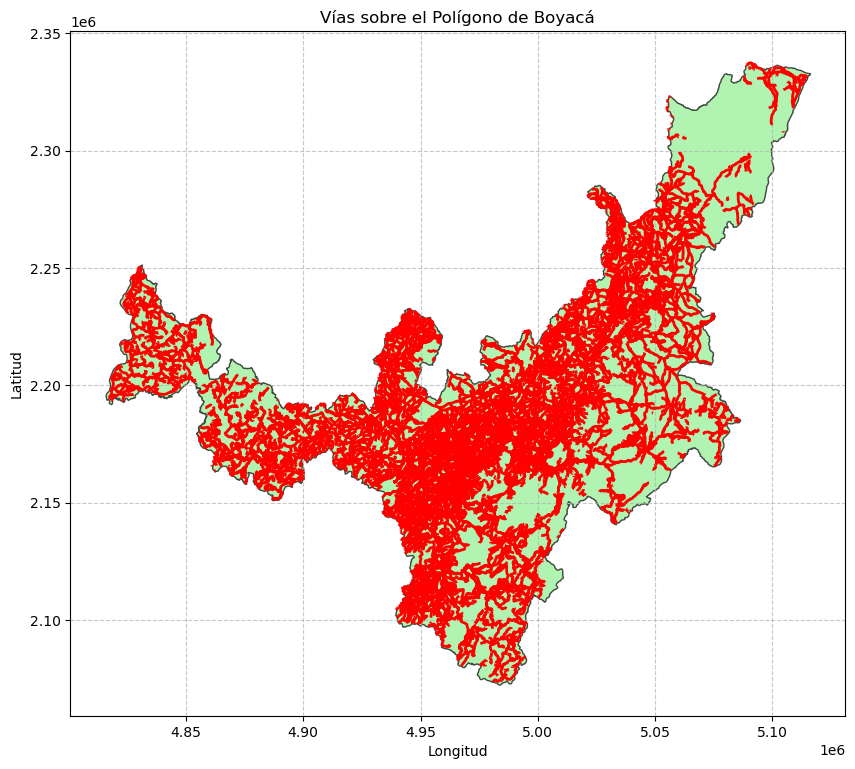

In [46]:
# --- Plotting (Visualización) ---
print("\n--- Generando el gráfico ---")
fig, ax = plt.subplots(1, 1, figsize=(10, 10)) # Crear figura y ejes explícitamente para mejor control

# Plotear el polígono de Boyacá (disuelto)
Boyaca_poligono.plot(ax=ax, color="lightgreen", edgecolor="black", alpha=0.7)

# Plotear las vías de Boyacá encima del polígono
if not Boyaca_vias.empty: # Solo plotea si hay vías
    Boyaca_vias.plot(ax=ax, color="red", linewidth=2)
    print("Vías ploteadas con éxito.")
else:
    print("Advertencia: Boyaca_vias está vacío, no se plotearon vías.")

ax.set_title("Vías sobre el Polígono de Boyacá")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [47]:
Boyaca = gdf_mun[gdf_mun["DPTO_CCDGO"].str.upper().str.contains("15")].copy()
Boyaca_bool = gdf_est.intersects(Boyaca.geometry.iloc[0])
Boyaca_stations = gdf_est[Boyaca_bool]
print(Boyaca_stations)


          Codigo                                             Nombre  \
2018    24035130                                 U P T C [24035130]   
4205  2401500086  UNIVERSIDAD PEDAGÓGICA Y TECNOLÓGICA DE COLOMB...   
6433    24030900                              COL ORTIZ  [24030900]   
6445    24030920                                  TUNJA  [24030920]   
8410    24030910                              SEMINARIO  [24030910]   

                Categoria      Estado Departamento Municipio  \
2018  Climática Principal      Activa       Boyacá     Tunja   
4205  Climática Principal      Activa       Boyacá     Tunja   
6433        Pluviométrica  Suspendida       Boyacá     Tunja   
6445        Pluviométrica  Suspendida       Boyacá     Tunja   
8410        Pluviométrica  Suspendida       Boyacá     Tunja   

                       Ubicación  Altitud Fecha_instalacion Fecha_suspension  \
2018   (5.5430775, -73.36081306)     2690        1962-02-15              NaN   
4205  (5.55361111, -73.35527

In [48]:
Boyaca.head()


,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,DPTO_CCDGO_NUM
637,15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,0.0,...,56563.0,43652.0,14337.0,3156.0,4044.0,0.572327,0.009766,15001,"POLYGON ((4959760.536 2172167.311, 4959767.787...",15
638,15,00022,ALMEIDA,15022,2018,5.757419e+07,4.954825,-73.388134,2649.0,0.0,...,514.0,83.0,18.0,88.0,16.0,0.348469,0.004702,15022,"POLYGON ((4959230.781 2111994.725, 4959364.58 ...",15
639,15,00047,AQUITANIA,15047,2018,9.402288e+08,5.437416,-72.871495,25311.0,0.0,...,4629.0,669.0,77.0,837.0,106.0,1.800311,0.076844,15047,"POLYGON ((5026299.41 2181056.535, 5026366.975 ...",15
640,15,00051,ARCABUCO,15051,2018,1.376690e+08,5.749565,-73.438880,4414.0,0.0,...,1913.0,461.0,66.0,178.0,28.0,0.752709,0.011257,15051,"POLYGON ((4944132.595 2203718.48, 4944172.143 ...",15
641,15,00087,BELÉN,15087,2018,1.627587e+08,6.005059,-72.893699,8167.0,0.0,...,2581.0,781.0,103.0,289.0,59.0,0.629349,0.013315,15087,"POLYGON ((5009188.804 2230505.691, 5009166.938...",15


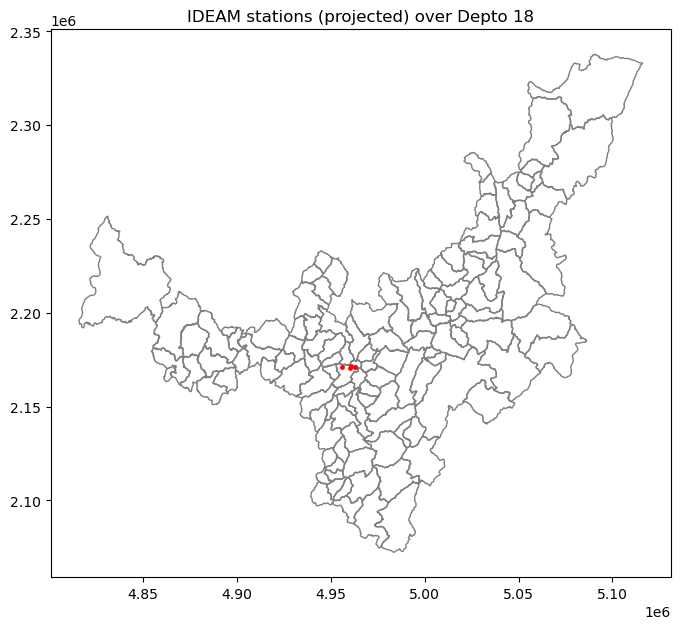

In [49]:
ax = Boyaca.plot(color="none", edgecolor="grey", figsize=(8, 8))
Boyaca_stations.plot(ax=ax, color="red", markersize=6)
plt.title("IDEAM stations (projected) over Depto 18")
plt.show()

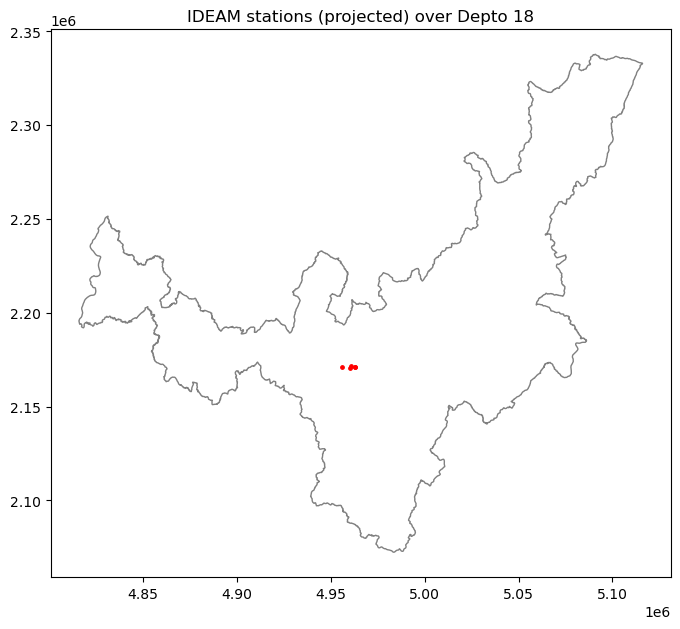

In [50]:
ax = Boyaca_poligono.plot(color="none", edgecolor="grey", figsize=(8, 8))
Boyaca_stations.plot(ax=ax, color="red", markersize=6)
plt.title("IDEAM stations (projected) over Depto 18")
plt.show()

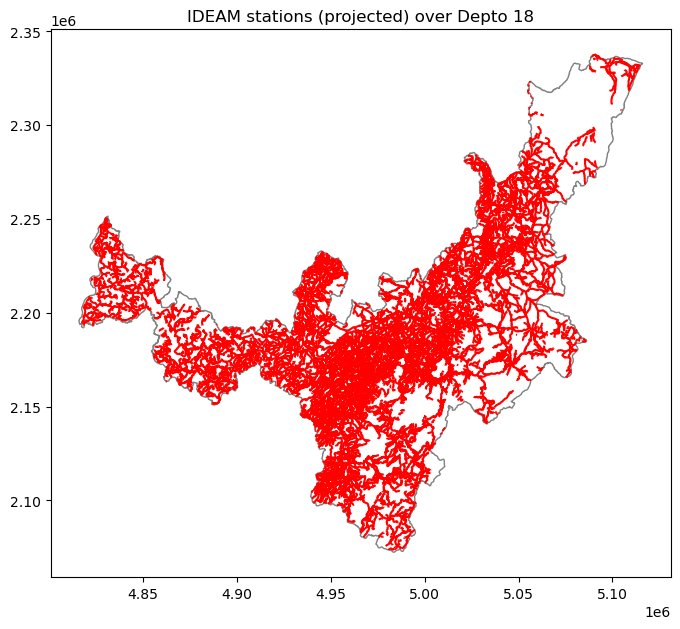

In [51]:
ax = Boyaca_poligono.plot(color="none", edgecolor="grey", figsize=(8, 8))
Boyaca_vias.plot(ax=ax, color="red", markersize=6)
plt.title("IDEAM stations (projected) over Depto 18")
plt.show()

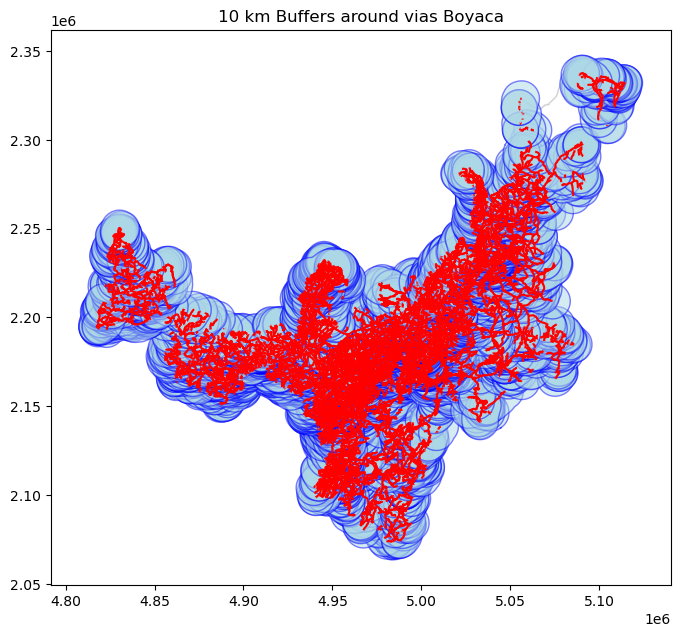

In [52]:

Boyaca_vias_copy = Boyaca_vias.copy()

# Create a 10 km buffer around each station
Boyaca_vias_copy['buffer_10km'] = Boyaca_vias_copy.geometry.buffer(10000)

# Visualise one example station buffer
ax = Boyaca_poligono.plot(color='none', edgecolor='lightgrey', figsize=(8, 8))

# Usa Boyaca_vias_copy para el buffer
gpd.GeoSeries(Boyaca_vias_copy['buffer_10km']).plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.5)
Boyaca_vias_copy.plot(ax=ax, color='red', markersize=20) # También usa la copia aquí

plt.title("10 km Buffers around vias Boyaca")
plt.show()

In [53]:
Boyaca_poligono.head()

,geometry,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,...,STP34_9_ED,STP51_PRIM,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun
DPTO_CCDGO_NUM,,,,,,,,,,,,,,,,,,,,,
15,"POLYGON ((4950411.628 2098204.312, 4950368.451...",15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,...,2820.0,35470.0,56563.0,43652.0,14337.0,3156.0,4044.0,0.572327,0.009766,15001


In [54]:
# 1. Spatial join: each station takes the attributes of the municipality it falls in
stations_with_mun = gpd.sjoin(
    Boyaca_stations,                     # left: point layer
    gdf_mun[["MPIO_CCDGO", "MPIO_CNMBR","MPIO_CCDGO", "geometry"]],  # right: polygon layer
    how="left",
    predicate="within"           # point inside polygon
)

# 2. Inspect the result
stations_with_mun[["Codigo", "MPIO_CNMBR", "MPIO_CCDGO"]].head()

,Codigo,MPIO_CNMBR,MPIO_CCDGO,MPIO_CCDGO
2018,24035130,TUNJA,00001,00001
4205,2401500086,TUNJA,00001,00001
6433,24030900,TUNJA,00001,00001
6445,24030920,TUNJA,00001,00001
8410,24030910,TUNJA,00001,00001


In [55]:
import numpy as np
import shapely

# Create a regular grid covering Colombia

# Bounds of the municipalities layer
bounds = gdf_mun.total_bounds
xmin, ymin, xmax, ymax = bounds

# Define grid resolution (example: 100 km x 100 km grid → 100_000 m)
res = 100000

# Build grid coordinates
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax + res)), res))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax + res)), res))
rows.reverse()

# Build polygons for each grid cell
polygons = []
for x in cols:
    for y in rows:
        polygons.append(
            shapely.Polygon([
                (x, y),
                (x + res, y),
                (x + res, y - res),
                (x, y - res)
            ])
        )

# Create grid GeoDataFrame
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_mun.crs)

# Remove cells that fall outside the total extent (intersect municipalities only)
sel = grid.intersects(shapely.box(*bounds))
grid = grid[sel]

# Add unique ID
grid['id'] = grid.index

grid.head()

,geometry,id
0,"POLYGON ((4047822 3090086, 4147822 3090086, 41...",0
1,"POLYGON ((4047822 2990086, 4147822 2990086, 41...",1
2,"POLYGON ((4047822 2890086, 4147822 2890086, 41...",2
3,"POLYGON ((4047822 2790086, 4147822 2790086, 41...",3
4,"POLYGON ((4047822 2690086, 4147822 2690086, 41...",4


In [56]:
eva.head()

,CÓD. \nDEP.,DEPARTAMENTO,cod_mun,MUNICIPIO,GRUPO \nDE CULTIVO,SUBGRUPO \nDE CULTIVO,CULTIVO,DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO,AÑO,PERIODO,Área Sembrada\n(ha),Área Cosechada\n(ha),Producción\n(t),Rendimiento\n(t/ha),ESTADO FISICO PRODUCCION,NOMBRE \nCIENTIFICO,CICLO DE CULTIVO
0,15,BOYACA,15114,BUSBANZA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,2,1,1,1.00,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
1,25,CUNDINAMARCA,25754,SOACHA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,82,80,1440,18.00,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
2,25,CUNDINAMARCA,25214,COTA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,2,2,26,17.33,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
3,54,NORTE DE SANTANDER,54405,LOS PATIOS,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,3,3,48,16.00,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
4,54,NORTE DE SANTANDER,54518,PAMPLONA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,1,1,5,10.00,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO


In [57]:
gdf_mun["MPIO_CCDGO"] = gdf_mun["MPIO_CCDGO"].astype(str).str.zfill(5)
eva["cod_mun"]        = eva["cod_mun"].astype(str).str.zfill(5)

In [58]:
# Calculate polygon area in square metres
gdf_vias['longitud'] = gdf_vias.length

gdf_vias.head()

,TIPO_VIA,ESTADO_SUP,NUMERO_CAR,ACCESIBILI,NOMBRE_GEO,PROYECTO,SYMBOL,FECHA,RULEID,PK_CUE,GLOBALID,EJE_VIAL,SHAPE_Leng,geometry,longitud
0,4,3306,3502,3600,<Null>,None,2,0000/00/00,4,6941149.0,{F25CEF82-A74B-44C7-BA1F-875D53B40633},None,9137.640673,"LINESTRING (4938813.822 2008654.982, 4939350.5...",9137.640673
1,1,3301,3501,3600,None,None,2,0000/00/00,1,2076843.0,{3553ECE2-56ED-45B1-BA51-2ECE88213217},None,7744.347798,"LINESTRING (4935376.98 2015283.87, 4936592.897...",7744.347798
2,1,3301,3501,3600,None,None,2,0000/00/00,1,1969851.0,{ED19F1EF-41C1-494E-A383-6A80FB377DF0},None,67046.435973,"LINESTRING (4914689.09 1993685.711, 4914705.81...",67046.435973
3,3,3301,3502,3600,None,None,2,0000/00/00,3,1969852.0,{A4ADF111-9441-4424-B31C-AB6839103435},None,1004.968141,"LINESTRING (4941162.794 2007465.638, 4940399.1...",1004.968141
4,4,3306,3502,3600,None,None,2,0000/00/00,4,1969853.0,{FB0921F6-EA65-4ABD-8979-EA98E0B93955},None,29460.903727,"LINESTRING (4917686.375 1999922.108, 4917887.8...",29460.903727


In [59]:
#vias_with_mun = gpd.sjoin(
 #   gdf_mun,                     # left: point layer
  #  gdf_vias[["longitud", "geometry"]],  # right: polygon layer
   # how="left",
    #predicate="intersects"           # point inside polygon
#)

# 2. Inspect the result
#vias_with_mun.head()


In [60]:
#gdf_interseccion = gdf_mun.overlay(vias_with_mun, how='intersection')
#gdf_interseccion.head()

In [61]:
#mun_grid = gdf_interseccion.overlay(grid)

# Keep only needed columns
#mun_grid = mun_grid[['MPIO_CNMBR', 'longitud', 'geometry']]

# Compute the area of each piece (intersection area)
#mun_grid['area_sub'] = mun_grid.area

#mun_grid.head()

In [62]:
#ax = mun_grid.plot(
 #   column='area_sub',
  #  edgecolor='black',
   # legend=True,
    #cmap='Reds',
   # figsize=(10, 10),
    #vmin=100000000,
   # vmax=10000000000
#)

# Title
#plt.title("Effect of .overlay:")
#plt.show()

In [63]:
import geopandas as gpd
from shapely.geometry import Polygon

In [64]:
# Calculate polygon area in square metres
Boyaca_vias_copy['longitud'] = Boyaca_vias_copy.length

Boyaca_vias_copy.head()

,TIPO_VIA,ESTADO_SUP,NUMERO_CAR,ACCESIBILI,NOMBRE_GEO,PROYECTO,SYMBOL,FECHA,RULEID,PK_CUE,GLOBALID,EJE_VIAL,SHAPE_Leng,geometry,buffer_10km,longitud
79812,7,Sin Valor,Sin Valor,Sin Valor,None,None,2,0000/00/00,7,2063030.0,{1347158E-BD91-4790-A668-90C102D3B197},None,483.013511,"LINESTRING (4984275.97 2074051.111, 4984300.66...","POLYGON ((4974435.418 2075806.735, 4974447.86 ...",483.013511
79734,6,3350,Sin Valor,3601,None,None,2,0000/00/00,6,2063313.0,{5ECE4F52-EF11-44E9-96D4-599E91137A82},None,3934.472217,"LINESTRING (4983788.075 2074377.709, 4983557.2...","POLYGON ((4979301.219 2084107.998, 4979965.611...",3934.472217
79715,6,3350,Sin Valor,3601,None,None,2,0000/00/00,6,2063930.0,{A6043EA0-285F-44B5-8579-89CE4E433020},None,672.713845,"LINESTRING (4983788.075 2074377.709, 4983788.0...","POLYGON ((4982228.342 2064271.27, 4981936.853 ...",672.713845
79811,7,Sin Valor,Sin Valor,Sin Valor,None,None,2,0000/00/00,7,2063029.0,{F3EBF78E-EFE3-4589-AAA2-5B5DCD2BA63C},None,905.835986,"LINESTRING (4984490.301 2075044.307, 4984461.7...","POLYGON ((4994426.713 2074027.921, 4994385.976...",905.835986
100560,6,3350,Sin Valor,3601,None,None,2,0000/00/00,6,2063929.0,{2ED8F17A-8C75-46CF-8D69-00F4A5EFC670},None,4651.688191,"LINESTRING (4986929.092 2074234.691, 4987019.1...","POLYGON ((4979607.017 2067441.041, 4979438.512...",4651.688191


In [65]:
Boyaca.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,DPTO_CCDGO_NUM
637,15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,0.0,...,56563.0,43652.0,14337.0,3156.0,4044.0,0.572327,0.009766,15001,"POLYGON ((4959760.536 2172167.311, 4959767.787...",15
638,15,00022,ALMEIDA,15022,2018,5.757419e+07,4.954825,-73.388134,2649.0,0.0,...,514.0,83.0,18.0,88.0,16.0,0.348469,0.004702,15022,"POLYGON ((4959230.781 2111994.725, 4959364.58 ...",15
639,15,00047,AQUITANIA,15047,2018,9.402288e+08,5.437416,-72.871495,25311.0,0.0,...,4629.0,669.0,77.0,837.0,106.0,1.800311,0.076844,15047,"POLYGON ((5026299.41 2181056.535, 5026366.975 ...",15
640,15,00051,ARCABUCO,15051,2018,1.376690e+08,5.749565,-73.438880,4414.0,0.0,...,1913.0,461.0,66.0,178.0,28.0,0.752709,0.011257,15051,"POLYGON ((4944132.595 2203718.48, 4944172.143 ...",15
641,15,00087,BELÉN,15087,2018,1.627587e+08,6.005059,-72.893699,8167.0,0.0,...,2581.0,781.0,103.0,289.0,59.0,0.629349,0.013315,15087,"POLYGON ((5009188.804 2230505.691, 5009166.938...",15


In [66]:
# Realizar la intersección
union_gdf = gpd.overlay(Boyaca, Boyaca_vias_copy,keep_geom_type=False)
union_gdf.tail()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,SYMBOL,FECHA,RULEID,PK_CUE,GLOBALID,EJE_VIAL,SHAPE_Leng,buffer_10km,longitud,geometry
8483,15,00332,GÜICÁN DE LA SIERRA,15332,2018,9.498998e+08,6.566992,-72.255993,4205.0,235.0,...,2,0000/00/00,7,2031922.0,{93517846-FC9F-4CE2-867A-6AA7F5CFAFF7},None,17214.676606,"POLYGON ((5071276.719 2293446.964, 5071890.157...",17214.676606,"LINESTRING (5080065.186 2288673.059, 5080141.6..."
8484,15,00332,GÜICÁN DE LA SIERRA,15332,2018,9.498998e+08,6.566992,-72.255993,4205.0,235.0,...,2,0000/00/00,7,2031918.0,{7021E8DE-88A2-4C19-9361-B316FF2975BE},None,1250.549521,"POLYGON ((5079455.025 2294957.178, 5079467.891...",1250.549521,"LINESTRING (5089463.276 2295552.629, 5089494.9..."
8485,15,00332,GÜICÁN DE LA SIERRA,15332,2018,9.498998e+08,6.566992,-72.255993,4205.0,235.0,...,2,0000/00/00,7,2031920.0,{A36665B1-EF99-486E-A0C2-2DE4634362D5},None,4336.661751,"POLYGON ((5079360.822 2288235.417, 5079023.638...",4336.661751,"LINESTRING (5089849.74 2297112.016, 5089823.67..."
8486,15,00332,GÜICÁN DE LA SIERRA,15332,2018,9.498998e+08,6.566992,-72.255993,4205.0,235.0,...,2,0000/00/00,7,2031919.0,{A5D7AEEC-A900-45C7-82A1-03159C767F0A},None,1225.536740,"POLYGON ((5092380.58 2287161.677, 5092308.437 ...",1225.536740,"LINESTRING (5090952.853 2297049.648, 5090933.8..."
8487,15,00332,GÜICÁN DE LA SIERRA,15332,2018,9.498998e+08,6.566992,-72.255993,4205.0,235.0,...,2,0000/00/00,7,2031921.0,{D22E11FC-FFBB-445D-B222-73D223CF1883},None,79.179690,"POLYGON ((5098742.302 2292543.285, 5098282.211...",79.179690,"LINESTRING (5089885.871 2297182.47, 5089868.20..."


In [67]:
#Para verificar si quedo bien el overlay
#Tunja_vias = union_gdf[union_gdf['MPIO_CCDGO']=='00332']
#Tunja_vias.head()

In [68]:
# Calculate polygon area in square metres
union_gdf['longitud_nueva'] = union_gdf.length

union_gdf.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,FECHA,RULEID,PK_CUE,GLOBALID,EJE_VIAL,SHAPE_Leng,buffer_10km,longitud,geometry,longitud_nueva
0,15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,0.0,...,0000/00/00,6,2065720.0,{30C02B20-7D51-4F37-9827-628B75FB2FA3},None,3553.335590,"POLYGON ((4948198.87 2163584.365, 4948196.171 ...",3553.335590,"LINESTRING (4958194.874 2163505.138, 4958220.6...",1528.992000
1,15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,0.0,...,0000/00/00,1,2085621.0,{DAFE8525-408D-4411-A0EA-30F7A1F28CC6},Bogotá-Tunja,104314.024437,"POLYGON ((4925883.427 2146606.892, 4925876.74 ...",40168.927864,"LINESTRING (4952315.375 2160321.599, 4952319.3...",14711.987328
2,15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,0.0,...,0000/00/00,4,6937210.0,{5AC1EABB-8359-44A0-AA1C-95694DCAAE8D},None,14474.167023,"POLYGON ((4941904.076 2159737.295, 4941906.484...",14474.167023,"LINESTRING (4955013.548 2160346.932, 4955014.0...",473.535712
3,15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,0.0,...,0000/00/00,5,2065729.0,{5AB35FCB-EEE0-4BC1-B50F-2E2F7F369ABB},None,2338.943231,"POLYGON ((4944775.248 2161620.787, 4944751.516...",2338.943231,"LINESTRING (4954751.507 2162104.411, 4954755.7...",2338.943231
4,15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,0.0,...,0000/00/00,6,7552201.0,{ADE2D1E8-D501-4920-9EF3-21348C0DD0CC},None,1363.027132,"POLYGON ((4945640.044 2161347.063, 4945638.737...",1363.027132,"LINESTRING (4956090.944 2161145.573, 4956086.9...",1101.643346


In [69]:
#para verificar si efectivamente se realizaron los ajustes

#print("antes",Tunja_vias.head(1))
#Tunja_vias["longitufd_guican"]=Tunja_vias.length
#print("despues",Tunja_vias.head(1))

In [70]:
#ax = Tunja_vias.plot(
#    column='longitud',
#    edgecolor='black',
#    legend=True,
#    cmap='Reds',
#    figsize=(10, 10),
#    vmin=100000000,
#    vmax=10000000000
#)

# Title
#plt.title("Effect of .overlay:")
#plt.show()

In [71]:
valores_unicos = union_gdf['Codigo_Mun'].unique()

# Imprimir los valores únicos
print("Valores únicos de la columna 'Codigo_Mun':")
print(valores_unicos)

Valores únicos de la columna 'Codigo_Mun':
[15001 15022 15047 15051 15087 15090 15092 15097 15104 15106 15109 15114
 15131 15135 15162 15172 15176 15183 15185 15187 15189 15204 15212 15215
 15377 15380 15401 15403 15542 15550 15572 15580 15755 15757 15759 15761
 15842 15861 15879 15897 15218 15224 15226 15232 15236 15238 15244 15248
 15272 15276 15293 15296 15299 15317 15322 15325 15362 15367 15368 15407
 15425 15442 15455 15464 15466 15469 15476 15480 15491 15494 15500 15507
 15511 15514 15516 15518 15522 15531 15533 15537 15599 15600 15621 15632
 15638 15646 15660 15664 15667 15673 15676 15681 15686 15690 15693 15696
 15720 15723 15740 15753 15762 15763 15764 15774 15776 15778 15790 15798
 15804 15806 15808 15810 15814 15816 15820 15822 15832 15835 15837 15839
 15180 15223 15332]


In [72]:
union_gdf['suma_vias_por_municipio'] = union_gdf.groupby('Codigo_Mun')['longitud_nueva'].cumsum()

union_gdf.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,RULEID,PK_CUE,GLOBALID,EJE_VIAL,SHAPE_Leng,buffer_10km,longitud,geometry,longitud_nueva,suma_vias_por_municipio
0,15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,0.0,...,6,2065720.0,{30C02B20-7D51-4F37-9827-628B75FB2FA3},None,3553.335590,"POLYGON ((4948198.87 2163584.365, 4948196.171 ...",3553.335590,"LINESTRING (4958194.874 2163505.138, 4958220.6...",1528.992000,1528.992000
1,15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,0.0,...,1,2085621.0,{DAFE8525-408D-4411-A0EA-30F7A1F28CC6},Bogotá-Tunja,104314.024437,"POLYGON ((4925883.427 2146606.892, 4925876.74 ...",40168.927864,"LINESTRING (4952315.375 2160321.599, 4952319.3...",14711.987328,16240.979328
2,15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,0.0,...,4,6937210.0,{5AC1EABB-8359-44A0-AA1C-95694DCAAE8D},None,14474.167023,"POLYGON ((4941904.076 2159737.295, 4941906.484...",14474.167023,"LINESTRING (4955013.548 2160346.932, 4955014.0...",473.535712,16714.515040
3,15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,0.0,...,5,2065729.0,{5AB35FCB-EEE0-4BC1-B50F-2E2F7F369ABB},None,2338.943231,"POLYGON ((4944775.248 2161620.787, 4944751.516...",2338.943231,"LINESTRING (4954751.507 2162104.411, 4954755.7...",2338.943231,19053.458271
4,15,00001,TUNJA,15001,2018,1.194849e+08,5.518473,-73.378019,79594.0,0.0,...,6,7552201.0,{ADE2D1E8-D501-4920-9EF3-21348C0DD0CC},None,1363.027132,"POLYGON ((4945640.044 2161347.063, 4945638.737...",1363.027132,"LINESTRING (4956090.944 2161145.573, 4956086.9...",1101.643346,20155.101617


In [73]:
union_gdf_geometria = union_gdf.geometry.geom_type.unique()
grid_geometria = grid.geometry.geom_type.unique()

print (union_gdf_geometria, 'union_gdf_geometria')

print (grid_geometria, 'grid_geometria')

['LineString' 'MultiLineString'] union_gdf_geometria
['Polygon'] grid_geometria


In [74]:
# 1. Spatial join: each station takes the attributes of the municipality it falls in
vias_por_mun = gpd.sjoin(
    union_gdf,                     # left: point layer
    gdf_mun[["MPIO_CCDGO", "MPIO_CNMBR","MPIO_CCDGO", "geometry"]],  # right: polygon layer
    how="left",
    predicate="within"           # point inside polygon
)

# 2. Inspect the result
vias_por_mun.tail()

,DPTO_CCDGO,MPIO_CCDGO_left,MPIO_CNMBR_left,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,SHAPE_Leng,buffer_10km,longitud,geometry,longitud_nueva,suma_vias_por_municipio,index_right,MPIO_CCDGO_right,MPIO_CNMBR_right,MPIO_CCDGO_right
8483,15,00332,GÜICÁN DE LA SIERRA,15332,2018,9.498998e+08,6.566992,-72.255993,4205.0,235.0,...,17214.676606,"POLYGON ((5071276.719 2293446.964, 5071890.157...",17214.676606,"LINESTRING (5080065.186 2288673.059, 5080141.6...",17214.676606,212514.115833,759.0,00332,GÜICÁN DE LA SIERRA,00332
8484,15,00332,GÜICÁN DE LA SIERRA,15332,2018,9.498998e+08,6.566992,-72.255993,4205.0,235.0,...,1250.549521,"POLYGON ((5079455.025 2294957.178, 5079467.891...",1250.549521,"LINESTRING (5089463.276 2295552.629, 5089494.9...",1250.549521,213764.665354,759.0,00332,GÜICÁN DE LA SIERRA,00332
8485,15,00332,GÜICÁN DE LA SIERRA,15332,2018,9.498998e+08,6.566992,-72.255993,4205.0,235.0,...,4336.661751,"POLYGON ((5079360.822 2288235.417, 5079023.638...",4336.661751,"LINESTRING (5089849.74 2297112.016, 5089823.67...",4336.661751,218101.327106,759.0,00332,GÜICÁN DE LA SIERRA,00332
8486,15,00332,GÜICÁN DE LA SIERRA,15332,2018,9.498998e+08,6.566992,-72.255993,4205.0,235.0,...,1225.536740,"POLYGON ((5092380.58 2287161.677, 5092308.437 ...",1225.536740,"LINESTRING (5090952.853 2297049.648, 5090933.8...",1225.536740,219326.863846,759.0,00332,GÜICÁN DE LA SIERRA,00332
8487,15,00332,GÜICÁN DE LA SIERRA,15332,2018,9.498998e+08,6.566992,-72.255993,4205.0,235.0,...,79.179690,"POLYGON ((5098742.302 2292543.285, 5098282.211...",79.179690,"LINESTRING (5089885.871 2297182.47, 5089868.20...",79.179690,219406.043536,759.0,00332,GÜICÁN DE LA SIERRA,00332


In [75]:
municipios_geom = gdf_mun[["MPIO_CCDGO", "geometry"]].rename(columns={"MPIO_CCDGO": "MPIO_CCDGO_left"})

# Sumar las longitudes por municipio y luego unir con la geometría del municipio
sumatoria_munic_df = vias_por_mun.groupby('MPIO_CCDGO_left')['longitud_nueva'].sum().reset_index()

# Ahora, convertir sumatoria_munic_df de nuevo a un GeoDataFrame, uniendo con las geometrías de los municipios.
# La clave para el join es 'MPIO_CCDGO_left' (o el nombre de la columna que usas para identificar el municipio).
sumatoria_munic = pd.merge(sumatoria_munic_df, municipios_geom, on='MPIO_CCDGO_left', how='left')

# Convertir el DataFrame resultante a un GeoDataFrame
sumatoria_munic = gpd.GeoDataFrame(sumatoria_munic, geometry='geometry')

print(sumatoria_munic)



    MPIO_CCDGO_left  longitud_nueva  \
0             00001   236594.780803   
1             00001   236594.780803   
2             00001   236594.780803   
3             00001   236594.780803   
4             00001   236594.780803   
..              ...             ...   
304           00861   258554.250916   
305           00861   258554.250916   
306           00861   258554.250916   
307           00879   125035.324303   
308           00897   134891.647896   

                                              geometry  
0    POLYGON ((4730856.146 1800689.038, 4730891.264...  
1    POLYGON ((4583956.385 1842864.917, 4584004.621...  
2    POLYGON ((4600986.881 1950709.248, 4601026.051...  
3    POLYGON ((4591580.43 1720502.753, 4591636.575 ...  
4    POLYGON ((4520163.776 1707949.672, 4520191.277...  
..                                                 ...  
304  POLYGON ((4950942.388 2161590.388, 4950962.193...  
305  POLYGON ((4915794.579 2282128.401, 4915811.096...  
306  POLYGON ((477

In [76]:
print(mun_grid.columns)

Index(['MPIO_CCDGO_left', 'longitud_nueva', 'id', 'geometry'], dtype='object')


In [77]:
# Ahora sí, sumatoria_munic es un GeoDataFrame y puedes usar overlay
mun_grid = sumatoria_munic.overlay(grid, how='intersection')

print('mun_grid', mun_grid)

# Keep only needed columns
# Es posible que los nombres de las columnas cambien ligeramente después del overlay,
# especialmente si 'MPIO_CNMBR_left' no se propaga directamente o si se generan duplicados.
# Revisa las columnas de 'mun_grid' después de la ejecución.
mun_grid = mun_grid[['MPIO_CNMBR', 'longitud_nueva', 'geometry']] # Asumo que 'longitud' es la suma de las vías

# Compute the area of each piece (intersection area)
mun_grid['area_sub'] = mun_grid.area

mun_grid.head()

mun_grid     MPIO_CCDGO_left  longitud_nueva   id  \
0             00001   236594.780803  138   
1             00001   236594.780803  139   
2             00001   236594.780803  117   
3             00001   236594.780803  116   
4             00001   236594.780803  118   
..              ...             ...  ...   
546           00861   258554.250916  198   
547           00861   258554.250916  176   
548           00861   258554.250916  157   
549           00879   125035.324303  198   
550           00897   134891.647896  198   

                                              geometry  
0    POLYGON ((4730891.264 1800687.527, 4730982.048...  
1    POLYGON ((4733986.939 1790054.988, 4733960.326...  
2    POLYGON ((4584004.621 1842828.996, 4584051.532...  
3    POLYGON ((4601026.051 1950708.042, 4601064.165...  
4    POLYGON ((4591636.575 1720501.392, 4591687.866...  
..                                                 ...  
546  POLYGON ((4950962.193 2161580.441, 4950980.038...  
547  P

KeyError: "['MPIO_CNMBR'] not in index"

In [ ]:
sumatoria_munic = vias_por_mun.groupby(['MPIO_CCDGO_left', 'AREA'])['longitud'].sum().reset_index()

print (sumatoria_munic)

In [ ]:
mun_grid = sumatoria_munic.overlay(grid, how='intersection')

print ('mun_grid', mun_grid)

#Keep only needed columns
mun_grid = mun_grid[['MPIO_CNMBR_left', 'suma_vias_por_municipio', 'geometry']]

# Compute the area of each piece (intersection area)
mun_grid['area_sub'] = mun_grid.area

mun_grid.head()